In [1]:

import os
import tqdm
from glob import glob
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model, Input
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,GlobalAvgPool2D,GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data=r'C:\Users\Sknja M\tomato'

In [3]:
Images=[]
import os
for dirname,_,filenames in os.walk(data):
    for filename in filenames:
        img=os.path.join(dirname,filename)
        Images.append(img)

In [4]:
class_label=[]
for i in Images:
    j=i.split('\\')
    class_label.append(j[-2])

In [5]:
import random

In [6]:
#shuffle two lists with same order
temp=list(zip(Images,class_label))
random.shuffle(temp)
Images,class_label=zip(*temp)
data=pd.DataFrame(list(zip(Images,class_label)),columns=['image_path','class_label'])

In [7]:
class_labels = data['class_label'].unique()
print(class_labels)


['Tomato___Late_blight' 'Tomato___Septoria_leaf_spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___healthy'
 'Tomato___Target_Spot' 'Tomato___Early_blight'
 'Tomato___Spider_mites Two-spotted_spider_mite'
 'Tomato___Tomato_mosaic_virus' 'Tomato___Bacterial_spot'
 'Tomato___Leaf_Mold']


In [8]:
from sklearn.utils import resample

# Dictionary to store resampled dataframes
resampled_data = {}

# Iterate over each class label
for label in class_labels:
    print(label)
    # Filter data for the current class label
    df = data[data['class_label'] == label]
    
    # Resample the dataframe
    resampled_df = resample(df, replace=True, n_samples=300, random_state=42)
    
    # Store the resampled dataframe in the dictionary
    resampled_data[label] = resampled_df


Tomato___Late_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___healthy
Tomato___Target_Spot
Tomato___Early_blight
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Tomato_mosaic_virus
Tomato___Bacterial_spot
Tomato___Leaf_Mold


In [9]:
import pandas as pd

# Convert dictionary values (dataframes) to a list
resampled_df_list = list(resampled_data.values())

# Concatenate the list of dataframes into a single dataframe
combined_resampled_df = pd.concat(resampled_df_list)

# Reset index of the combined dataframe
combined_resampled_df.reset_index(drop=True, inplace=True)

# Display the combined dataframe
print(combined_resampled_df)


                                             image_path           class_label
0     C:\Users\Sknja M\tomato\Tomato___Late_blight\9...  Tomato___Late_blight
1     C:\Users\Sknja M\tomato\Tomato___Late_blight\d...  Tomato___Late_blight
2     C:\Users\Sknja M\tomato\Tomato___Late_blight\2...  Tomato___Late_blight
3     C:\Users\Sknja M\tomato\Tomato___Late_blight\e...  Tomato___Late_blight
4     C:\Users\Sknja M\tomato\Tomato___Late_blight\7...  Tomato___Late_blight
...                                                 ...                   ...
2995  C:\Users\Sknja M\tomato\Tomato___Leaf_Mold\538...    Tomato___Leaf_Mold
2996  C:\Users\Sknja M\tomato\Tomato___Leaf_Mold\c9c...    Tomato___Leaf_Mold
2997  C:\Users\Sknja M\tomato\Tomato___Leaf_Mold\87b...    Tomato___Leaf_Mold
2998  C:\Users\Sknja M\tomato\Tomato___Leaf_Mold\068...    Tomato___Leaf_Mold
2999  C:\Users\Sknja M\tomato\Tomato___Leaf_Mold\770...    Tomato___Leaf_Mold

[3000 rows x 2 columns]


In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode labels numerically
label_encoder = LabelEncoder()
combined_resampled_df['y_encoded'] = label_encoder.fit_transform(combined_resampled_df['class_label'])

In [11]:
def resize_image(img_path):
    # Read the image
    file = cv2.imread(img_path)
    
    # Resize the image
    resized = cv2.resize(file, (128, 128), interpolation=cv2.INTER_AREA)
    resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    resized = resized / 255
    resized= np.array(resized)
    # Reshape the resized image
    return resized

In [12]:
import cv2

In [13]:
images = []
for i in combined_resampled_df['image_path']:
    file_name, file_extension = os.path.splitext(i)
    if file_extension == '.db':
        print(file_name)
    else:
        app = resize_image(i)
        images.append(app)

In [14]:
class_names = list(combined_resampled_df['class_label'])

In [15]:
images[0].shape

(128, 128, 3)

In [16]:
len(images)

3000

In [17]:
len(class_names)

3000

In [18]:
#images.shape
images=np.array(images)
images.shape

(3000, 128, 128, 3)

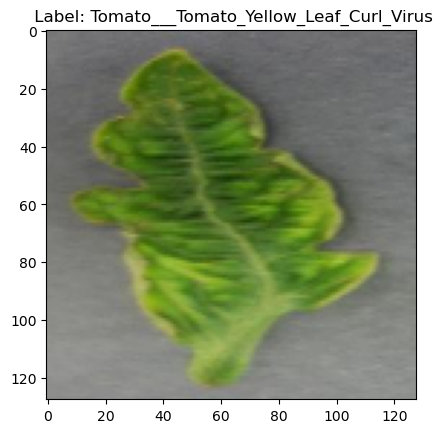

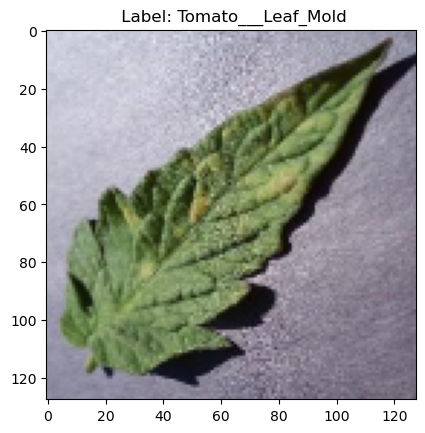

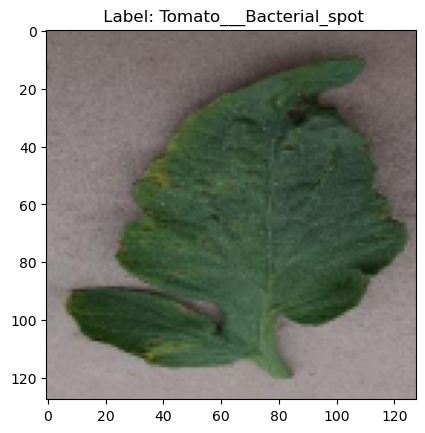

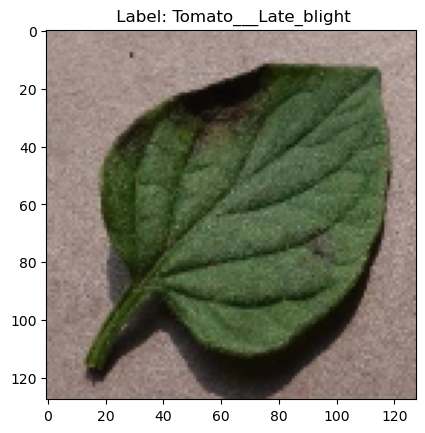

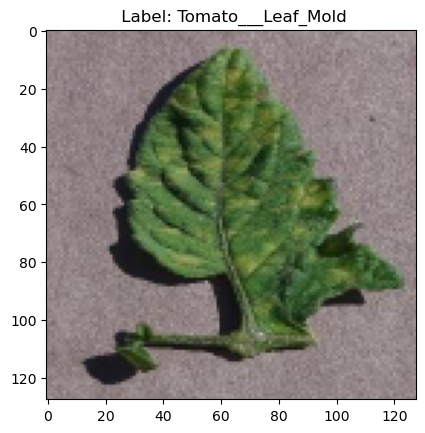

In [19]:
# Randomly choose 5 indices
random_indices = random.sample(range(len(images)), 5)

# Display 5 randomly chosen images with labels
for idx in random_indices:
    resized_img = images[idx]

    label = combined_resampled_df['class_label'][idx]  # Assuming label is stored in the 'label' column of your dataset
    plt.imshow(resized_img)
    plt.title(f" Label: {label}")
    #plt.axis('off')
    plt.show()

In [20]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(combined_resampled_df['class_label'])

In [21]:
enc.classes_

array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Leaf_Mold',
       'Tomato___Septoria_leaf_spot',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U45')

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2,stratify = y,random_state=2)

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2400, 128, 128, 3), (2400, 10), (600, 128, 128, 3), (600, 10))

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2400, 128, 128, 3), (600, 128, 128, 3), (2400, 10), (600, 10))

In [25]:

input_shape = X_train[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [26]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inception = InceptionV3(input_shape=(128,128,3), input_tensor=model_input, include_top=False, weights=None)


In [27]:
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Add a fully connected layer
prediction1 = Dense(10,activation='softmax')(x) # Add a classification layer

# Combine the base model with your custom layers
inpv3 = Model(model_input, outputs=prediction1)


# Print model summary
inpv3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 63, 63, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 63, 63, 32)        │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 63, 63, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 61, 61, 32)        │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 61, 61, 32)        │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 61, 61, 32)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 61, 61, 64)        │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 61, 61, 64)        │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 61, 61, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 30, 30, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 30, 30, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 30, 30, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 30, 30, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 28, 28, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,066,346 (84.18 MB)

 Trainable params: 22,031,914 (84.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [28]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define your callbacks
EarlyStop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
Checkpoint = ModelCheckpoint(monitor='val_accuracy', filepath=r'inpv3-model.keras', verbose=1, save_best_only=True, mode='auto')
callbacks = [EarlyStop, Checkpoint]

# Define your optimizer
adam = keras.optimizers.Adam(learning_rate=0.0001)

# Compile your model
inpv3.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [74]:
hi= inpv3.fit(X_train, y_train, epochs = 10,validation_data = (X_test,y_test), batch_size =32)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.2603 - loss: 2.0856 - val_accuracy: 0.1000 - val_loss: 2.3882
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.5494 - loss: 1.2981 - val_accuracy: 0.1000 - val_loss: 3.2280
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6479 - loss: 0.9823 - val_accuracy: 0.1167 - val_loss: 2.8878
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7387 - loss: 0.7448 - val_accuracy: 0.1017 - val_loss: 2.8287
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7850 - loss: 0.6422 - val_accuracy: 0.1133 - val_loss: 3.8406
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8365 - loss: 0.4387 - val_accuracy: 0.1517 - val_loss: 4.9982
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8316 - loss: 0.4925 - val_accuracy: 0.2600 - val_loss: 3.1758
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.8447 - loss: 0.4376 - val_accuracy: 0.4900 - v

In [75]:
model = inpv3

Import image path:  C:\Users\Sknja M\tomato\Tomato___Tomato_mosaic_virus\000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG


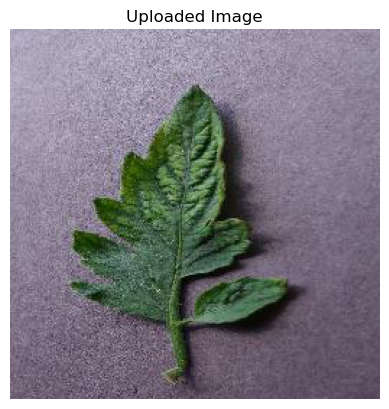

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


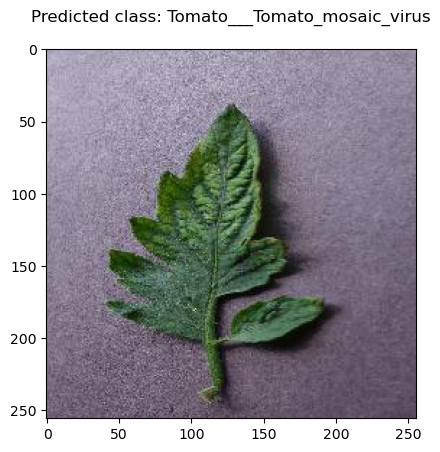

In [86]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_SIZE = (128, 128)
# Function to preprocess the image
def preprocess_image(image):
    image = image.resize(IMAGE_SIZE)
    image_array = np.array(image) / 255.0
    return np.expand_dims(image_array, axis=0)

# Function to predict using the model
def predict_image(model, image):
    preprocessed_image = preprocess_image(image)
    prediction = np.argmax(model.predict(preprocessed_image))
    return prediction

# Prompt the user to input the file path
file_path = input(r"Import image path: ")
image = Image.open(file_path)

# Display the uploaded image
plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# Make prediction
prediction = predict_image(model, image)
# Display prediction result
predicted_class = np.argmax(prediction)
confidence_score = np.max(prediction)
plt.title("Predicted class: {}\n".format(enc.classes_[prediction]))
plt.imshow(image)